In [98]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import powerlaw
import matplotlib.pyplot as plt 

In [99]:
# Read files
actes = ['13','14','15','18','20','21','22','23','24']
df = pd.read_csv('GJacte13.csv')
df['acte'] = [13]*len(df)
for acte in actes[1:]:
    dfi = pd.read_csv('GJacte'+acte+'.csv')
    dfi['acte'] = [int(acte)]*len(dfi)
    df = pd.concat([df,dfi],ignore_index=True)

C:\Users\Felipe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [100]:
# There are no retweets
df.is_retweet.value_counts()
#df.is_quote.value_counts()

False    163373
Name: is_retweet, dtype: int64

### Try to eliminate troll accounts

In [101]:
df = df[~df['screen_name'].str.contains('[Tt]roll')]
df = df[~df['screen_name'].str.contains('tv|TV|radio|journaux')]
df = df[df['followers_count'] > 0]
df = df[df['friends_count'] > 0]

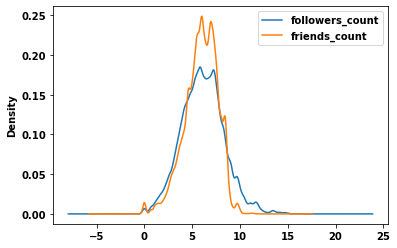

In [102]:
df[['followers_count','friends_count']].apply(np.log).plot.kde();

In [103]:
q = [0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999]
df[['followers_count','friends_count']].apply(np.log).quantile(q)

,followers_count,friends_count
0.100,3.332205,3.663562
0.250,4.605170,4.897840
0.500,6.075346,6.061457
0.750,7.499977,7.158514
0.900,8.842893,8.026497
0.950,9.793673,8.465310
0.990,11.819417,9.157045
0.999,14.525414,10.076180


In [104]:
print(df[['screen_name','followers_count']].sort_values('followers_count',ascending = False))
print(df[['screen_name','friends_count']].sort_values('friends_count',ascending = False))

        screen_name  followers_count
161898    lemondefr          8182478
161896    lemondefr          8182478
161897    lemondefr          8182478
146365    lemondefr          8170396
129052    lemondefr          8152760
...             ...              ...
78500   Halya_Iriss                1
78499   Halya_Iriss                1
78498   Halya_Iriss                1
3235      horloge31                1
162523  HectorZabor                1

[158913 rows x 2 columns]
           screen_name  friends_count
33375   WilliamOmbagho         124936
76873   WilliamOmbagho         124335
82405   WilliamOmbagho         124004
89855   IndigndeVerdad         117544
89860   IndigndeVerdad         117544
...                ...            ...
24757      KairosNeige              1
162731    singenhiver1              1
162732    singenhiver1              1
24756      KairosNeige              1
95201     Yvon_Mbaiser              1

[158913 rows x 2 columns]


In [105]:
q1 = df['followers_count'].apply(np.log).quantile(0.99)
q2 = df['friends_count'].apply(np.log).quantile(0.99)

df = df[np.logical_and(df['followers_count'].apply(np.log) < q1,df['friends_count'].apply(np.log) < q2)]
len(df)

155727

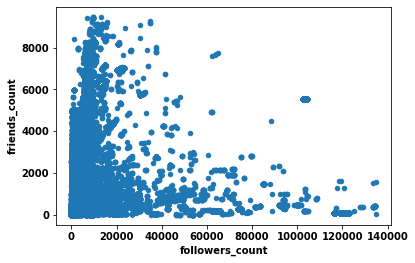

In [106]:
df.plot.scatter('followers_count','friends_count');

###  Prepare hashtags and mentioned users

In [107]:
def prep_list_text(x):
    if pd.isnull(x):
        pass
    else:
        # replace some characters
        x = re.sub("c\(","",x)
        x = re.sub("\)","",x)
        x = re.sub("\"","",x)
        # to lower case
        x = x.lower()
        return(x)


df['hashtags'] = df['hashtags'].apply(lambda x: prep_list_text(x))
df['mentions_screen_name'] = df['mentions_screen_name'].apply(lambda x: prep_list_text(x))

### Hashtags and mentioned users to edge list

In [108]:
import re
from itertools import combinations 

# Given a list of hashtags, it generates a list of all possible links.
def hashtag2list(x):
    x = x.split(", ")
    if len(x)>1:
        return([i for i in combinations(x,2)])
    else:
        pass

# Given a user and list of mentioned users, it generates a list of all possible links.
# s: source user
# t: mentioned users

def users2list(s,t):
    if pd.isnull(t):
        pass
    else:
        t = t.split(", ")
        return([(s,i) for i in t])

### Create edge lists (t <= t')

In [109]:
import copy

# Edge
ht_edgelists = {}
hashtags_edgelist = []
for acte in df.acte.unique():
    for x in df.hashtags[df.acte == acte].values:
        ht = hashtag2list(x)
        if ht is not None:
            hashtags_edgelist += ht
    ht_edgelists[acte] = copy.deepcopy(hashtags_edgelist)
            
users_edgelists = {}
users_edgelist = []        
for acte in df.acte.unique():
    for k in list(df[df.acte == acte].index):        
        u = users2list(df['screen_name'].loc[k], df['mentions_screen_name'].loc[k])
        if u is not None:
            users_edgelist += u 
    users_edgelists[acte] = copy.deepcopy(users_edgelist)

In [110]:
print([len(i) for i in ht_edgelists.values()])
print([len(i) for i in users_edgelists.values()])


[174927, 260883, 369658, 473089, 600477, 731055, 862793, 968880, 1087465]
[31584, 36566, 52372, 65868, 82429, 99042, 115793, 130737, 146134]


In [111]:
for v in list(ht_edgelists.keys()):
    ht_edgelists[v] = pd.value_counts(ht_edgelists[v])
    users_edgelists[v] = pd.value_counts(users_edgelists[v])

In [112]:
print([len(i) for i in ht_edgelists.values()])
print([len(i) for i in users_edgelists.values()])

[61785, 66915, 98805, 123971, 155850, 185971, 218556, 244205, 275080]
[24439, 25841, 36677, 45991, 56075, 65930, 75665, 84641, 93148]


# Network of Hashtags

In [113]:
# Weighted networks
gs = {}
for i,v in ht_edgelists.items():
    # Clean the edgelist a bit
    htel = copy.deepcopy(v)
    htel = htel.to_frame(name = 'freq')
    htel['id'] = [str(x) for x in htel.index]
    htel = htel[~htel.id.str.contains('jaune', regex = False)]
    htel = htel.sort_values(by='freq')
    
    # Create a weighted undirected networks
    ht_g = nx.Graph() 
    ht_g.add_weighted_edges_from([tuple(list(htel.index[k])+[htel.freq.iloc[k]]) for k in range(len(htel))])
    gs[i] = ht_g

In [114]:
print('Are the networks connected?', [nx.is_connected(g) for g in gs.values()])
print('Sizes of the 5 largest weakly connected components:\n', 
      [[len(c) for c in sorted(nx.connected_components(g),key=len, reverse=True)][:5] for g in gs.values()])

Are the networks connected? [False, False, False, False, False, False, False, False, False]
Sizes of the 5 largest weakly connected components:
 [[6277, 8, 8, 7, 5], [6681, 8, 8, 7, 5], [9223, 8, 8, 7, 5], [11047, 9, 8, 8, 7], [13328, 13, 9, 8, 8], [15321, 13, 11, 9, 8], [17421, 13, 11, 9, 8], [19025, 11, 9, 8, 6], [20908, 11, 6, 5, 5]]


In [115]:
### Keep the largest weakly connected component
for i,v in gs.items():
    gs[i] = v.subgraph(max(nx.connected_components(v), key=len))    

### Evolution of the system size (relative to the final size)

In [117]:
print([len(g.nodes()) for g in gs.values()])
print([len(g.edges()) for g in gs.values()])

[6277, 6681, 9223, 11047, 13328, 15321, 17421, 19025, 20908]
[44499, 48179, 72114, 91034, 115139, 138239, 163297, 183188, 207445]


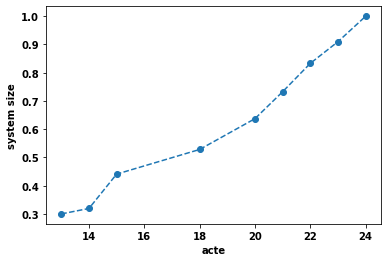

In [118]:
# Plot system size 
g_size = np.array([len(g) for g in gs.values()])
plt.plot(list(gs.keys()), 1/g_size[-1]*g_size,'--o')
plt.xlabel('acte')
plt.ylabel('system size');

### Plotting the CCDF of the degree distribution and strength distribution in log-log scale.

In [119]:
k_ = {}
s_ = {}

for i,v in gs.items():
    k_[i] = [i[1] for i in list(v.degree())] # degree
    s_[i] = [i[1] for i in list(v.degree(weight = 'weight'))] # strength

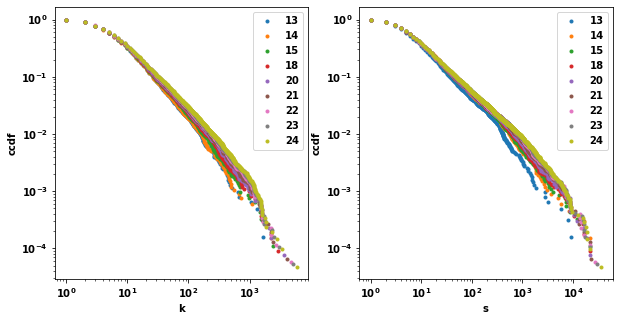

In [120]:
fig1, ax = plt.subplots(1, 2, figsize = (10, 5)) 
for i in k_.keys():
    powerlaw.plot_ccdf(k_[i], linestyle="", marker=".", ax = ax[0], label = i)
    ax[0].set_ylabel(u"ccdf")
    ax[0].set_xlabel(r"k")
    ax[0].legend();

    powerlaw.plot_ccdf(s_[i], linestyle="",marker=".", ax = ax[1], label = i)
    ax[1].set_ylabel(u"ccdf")
    ax[1].set_xlabel(r"s")
    ax[1].legend(); 

In [121]:
res_fit = pd.DataFrame(gs.keys(), columns = ['acte'])
res_fit_ = [powerlaw.Fit(x, discrete=True) for x in s_.values()]
res_fit['alpha_s'] = [round(x.alpha, 3) for x in res_fit_]
res_fit['sigma_s'] = [round(x.sigma, 3) for x in res_fit_]

print(res_fit)

Calculating best minimal value for power law fit
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


   acte  alpha_s  sigma_s
0    13    1.928    0.019
1    14    1.892    0.028
2    15    1.888    0.016
3    18    1.875    0.015
4    20    1.873    0.015
5    21    1.843    0.014
6    22    1.830    0.010
7    23    1.828    0.010
8    24    1.823    0.012


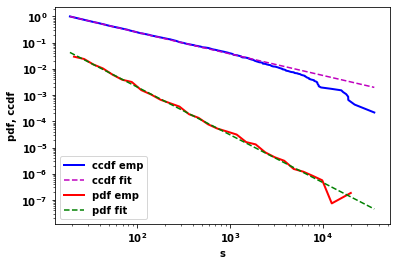

In [122]:
fig04 = res_fit_[-1].plot_ccdf(color='b', linewidth=2, label = 'ccdf emp')
res_fit_[-1].power_law.plot_ccdf(color='m', linestyle='--', ax=fig04, label = 'ccdf fit')
res_fit_[-1].plot_pdf(color='r', linewidth=2, label = 'pdf emp')
res_fit_[-1].power_law.plot_pdf(color='g', linestyle='--', ax=fig04, label = 'pdf fit')

fig04.set_ylabel(u"pdf, ccdf")
fig04.set_xlabel(r"s")
fig04.legend();

### Goodness of fit
NOTE THAT IT WILL TAKE A WHILE!

In [43]:
def get_pval(nsim,v,fit):
    Ds_simulated = [None]*nsim # list of synthetic KS statistics
    v_head = np.array([v[i] for i in range(len(v)) if v[i] < int(fit.xmin)])

    for k in range(nsim):
        theoretical_distribution = powerlaw.Power_Law(xmin=fit.xmin, parameters=[fit.alpha])
        simulated_v = theoretical_distribution.generate_random(round(fit.n_tail)) # simulated tail v
        simulated_v = np.append(v_head, simulated_v) # put together simulated tail with real head
        fit_simulated = powerlaw.Fit(simulated_v, verbose=True)
        Ds_simulated[k] = fit_simulated.D
    Ds_simulated = np.array(Ds_simulated)
    pval = len(Ds_simulated[Ds_simulated > fit.D]) / len(Ds_simulated)
    return(pval)

In [46]:
nsim = 100 # number of synthetic k_in sets

pval_ = []
for i,e in enumerate(list(s_.keys())):
    pval_.append(get_pval(nsim,s_[e],res_fit_[i]))
    
res_fit['pval_in'] = pval_

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

In [48]:
res_fit.round(3)    

,acte,alpha_s,sigma_s,pval_in
0,13,1.928,0.019,0.19
1,14,1.892,0.028,0.21
2,15,1.888,0.016,0.00
3,18,1.875,0.015,0.52
4,20,1.873,0.015,0.14
5,21,1.843,0.014,0.10
6,22,1.830,0.010,0.36
7,23,1.828,0.010,0.12
8,24,1.823,0.012,0.68


The power law hypothesis cannot be rejected.

### Fitting alternative distributions, and comparing their fit with the power law fit

In [51]:
def res_compare(myfit, alternative = 'lognormal'):    
    R,p = myfit.distribution_compare('power_law', alternative)
    return([R,p])

res_fit[['R_ln','p_ln']] = pd.DataFrame([res_compare(i) for i in res_fit_]).round(3)   
res_fit[['R_exp','p_exp']] = pd.DataFrame([res_compare(i, alternative = 'exponential') for i in res_fit_]).round(5)

In [54]:
res_fit.round(3)   

,acte,alpha_s,sigma_s,pval_in,R_ln,p_ln,R_exp,p_exp
0,13,1.928,0.019,0.19,-1.193,0.324,1951.369,0.0
1,14,1.892,0.028,0.21,-2.251,0.201,765.528,0.0
2,15,1.888,0.016,0.00,-0.969,0.389,2903.760,0.0
3,18,1.875,0.015,0.52,-0.751,0.441,3619.592,0.0
4,20,1.873,0.015,0.14,-0.167,0.691,3581.791,0.0
5,21,1.843,0.014,0.10,-1.406,0.286,3603.673,0.0
6,22,1.830,0.010,0.36,-1.431,0.289,7555.953,0.0
7,23,1.828,0.010,0.12,-1.312,0.306,8445.507,0.0
8,24,1.823,0.012,0.68,-3.046,0.121,4630.239,0.0


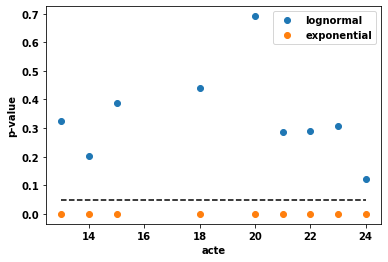

In [55]:
plt.plot(res_fit['acte'], res_fit['p_ln'], 'o', label = 'lognormal')
plt.plot(res_fit['acte'], res_fit['p_exp'],'o', label = 'exponential')
plt.hlines(0.05, xmin = min(res_fit['acte']), xmax = max(res_fit['acte']), linestyle="--")
plt.xlabel('acte')
plt.ylabel('p-value')
plt.legend();

We cannot reject the hypothesis that lognormal fit is equally likely than power law fit, but we note that the estimated mean is negative for the lognormal distribution. On the other hand, we can reject the hypothesis that exponential fit is equally likely than power law fit.

In [57]:
print('Parameters of the lognormal distribution: ')
print("mu: " + str(round(res_fit_[-1].lognormal.mu, 3)))
print("sigma: " + str(round(res_fit_[-1].lognormal.sigma, 3)))

print('Parameters of the exponential distribution: ')
print("lambda: " + str(round(res_fit_[-1].exponential.Lambda, 3)))

Parameters of the lognormal distribution: 
mu: -24.547
sigma: 6.017
Parameters of the exponential distribution: 
lambda: 0.005


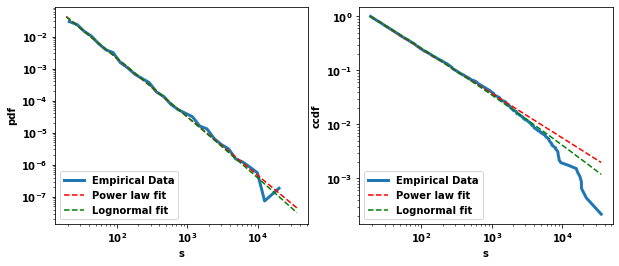

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
res_fit_[-1].plot_pdf(ax= ax[0], linewidth=3, label='Empirical Data')
res_fit_[-1].power_law.plot_pdf(ax=ax[0], color='r', linestyle='--', label='Power law fit')
res_fit_[-1].lognormal.plot_pdf(ax=ax[0], color='g', linestyle='--', label='Lognormal fit')

ax[0].set_ylabel(u"pdf")
ax[0].set_xlabel("s")
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc=3);

res_fit_[-1].plot_ccdf(ax= ax[1], linewidth=3, label='Empirical Data')
res_fit_[-1].power_law.plot_ccdf(ax=ax[1], color='r', linestyle='--', label='Power law fit')
res_fit_[-1].lognormal.plot_ccdf(ax=ax[1], color='g', linestyle='--', label='Lognormal fit')

ax[1].set_ylabel(u"ccdf")
ax[1].set_xlabel("s")
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, loc=3);

In [125]:
# Hubs
sorted(list(gs[24].degree(weight = 'weight')),key = lambda x: x[1], reverse = True)

[('macron', 35846),
 ('actexiv', 22022),
 ('france', 18813),
 ('paris', 18758),
 ('yellowvests', 17858),
 ('acte14', 16552),
 ('ric', 15833),
 ('lrem', 12310),
 ('castaner', 9584),
 ('actexx', 9051),
 ('lci', 9004),
 ('cnews', 8836),
 ('acte18', 8750),
 ('bfmtv', 8729),
 ('actexv', 8507),
 ('actexxi', 8091),
 ('acte23', 8044),
 ('violencespolicieres', 7518),
 ('acte15', 7154),
 ('acte21', 7134),
 ('acte20', 6924),
 ('actexxii', 6684),
 ('acte24', 6593),
 ('gj', 6440),
 ('benalla', 6406),
 ('acte22', 6136),
 ('actexxiii', 5917),
 ('actexviii', 5784),
 ('macrondemission', 5710),
 ('europe', 5420),
 ('yellowvest', 5367),
 ('lbd', 5002),
 ('actexxiv', 4924),
 ('toulouse', 4892),
 ('isf', 4572),
 ('resistance', 4449),
 ('granddebat', 4337),
 ('bordeaux', 4249),
 ('franceinfo', 4076),
 ('stylosrouges', 3989),
 ('police', 3982),
 ('politique', 3951),
 ('flashball', 3880),
 ('macronhautetrahison', 3721),
 ('rictoutesmatieres', 3676),
 ('larem', 3673),
 ('frexit', 3627),
 ('jeromerodrigues', 35

In [126]:
# Average clustering
nx.average_clustering(gs[24])

0.727454990392938

### Is there burstiness in hashtags co-appeareance?

In [59]:
# Strengths with keys
s__ = {}

for i,v in gs.items():
    s__[i] = dict(v.degree(weight = 'weight')) # strength

In [60]:
# Sort nodes with k-largest in/out-strength when the whole system is built up
d_s_ = list(gs[max(gs.keys())].degree(weight = 'weight'))
d_s_ = sorted(d_s_, key = lambda x: x[1], reverse = True)

In [61]:
# Get strength of hashtag along different periods
def get_user_strength(user):
    x = [v[user] if user in v.keys() else 0 for v in s__.values()]
    return(np.array(x))

# Get logarithmic derivative
def log_deriv(user_strength):
    a = np.divide(np.diff(user_strength),user_strength[:-1])
    a[np.logical_or(a == np.inf,  a == -np.inf)] = None
    return(a)

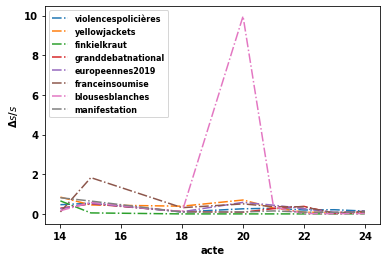

In [96]:
# Plot the logarithmic derivative
#k = 12
fig, ax = plt.subplots(1,1, figsize = (6,4)) 
#for user in [x[0] for x in d_s_][:k]:
for user in [x[0] for x in d_s_][50:58]:    
    ax.plot(list(s__.keys())[1:],log_deriv(get_user_strength(user)), linestyle = '-.', label = user)
    
ax.set_xlabel('acte')
ax.set_ylabel(r'$\Delta s/s$')
ax.legend(fontsize=8);

Burst size distribution

In [68]:
# Get average logartithmic derivatives of s_in and s_out for all users
av_ld_users_s_ = []
for user in list(gs[max(gs.keys())].nodes()):
    y_ = log_deriv(get_user_strength(user))
    av_ld_users_s_.append(np.nanmean([i for i in y_ if i is not None]))

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Values less than or equal to 0 in data. Throwing out 0 or negative values
C:\Users\Felipe\Anaconda3\lib\site-packages\powerlaw.py:101: RuntimeWarning: invalid value encountered in greater
  self.data = self.data[self.data>0]
Calculating best minimal value for power law fit


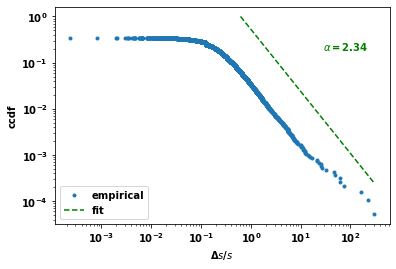

In [69]:
fig1, ax = plt.subplots(1, 1) 
powerlaw.plot_ccdf([x for x in av_ld_users_s_ if np.isfinite(x)], linestyle="", marker=".", ax = ax, label = r"empirical")
# add fitted curves
f_ = powerlaw.Fit(av_ld_users_s_)
f_.power_law.plot_ccdf(color='g', linestyle='--', ax = ax, label = r'fit')
# add fitted values of exponents
ax.text(.8,.8,r"$\alpha = $"+str(np.round(f_.alpha, 2)), color='g', transform=ax.transAxes)

ax.set_ylabel(u"ccdf")
ax.set_xlabel(r'$\Delta s/s$')
ax.legend(loc = 'lower left');

In [78]:
# Save data frame of hashtags
df[['hashtags','acte']].to_csv('ht_df.csv',index = False)